# Extracting Events From CSN

Notice that this extract data from de Centro Sismologico Nacional from Chile (http://evtdb.csn.uchile.cl/events)

## Extracting Function

In [1]:
def extract_csn():
    import sys
    import requests
    from bs4 import BeautifulSoup
    import re
    import unicodedata
    import pandas as pd
    import numpy as np
    time=[]; lat=[]; long=[];depth=[];mag=[]
    url_p = "http://evtdb.csn.uchile.cl/events?page=1"
    response_p = requests.get(url_p)
    data_p = response_p.text
    soup_p = BeautifulSoup (data_p, 'html5lib')
    html_p = []
    for t in soup_p.find_all('li'):
        html_p.append(t)
    n_pags = int(html_p[9].get_text("|", strip=True)[-3:])
    for i in range(n_pags):
        url = "http://evtdb.csn.uchile.cl/events?page={}".format(i+1)
        response = requests.get(url)
        data = response.text
        soup = BeautifulSoup (data, 'html5lib')
        html_tables = []
        for t in soup.find_all('tr'):
            html_tables.append(t)
        for e in range(8,len(html_tables)):
            tm = html_tables[e].find_all('td')[0].get_text("|", strip=True)
            lt = html_tables[e].find_all('td')[1].get_text("|", strip=True)
            ln = html_tables[e].find_all('td')[2].get_text("|", strip=True)
            dp = html_tables[e].find_all('td')[3].get_text("|", strip=True)
            mg = html_tables[e].find_all('td')[4].get_text("|", strip=True)
            time.append(tm);lat.append(lt);long.append(ln);depth.append(dp);mag.append(mg)
    return time,lat,long,depth,mag

In [2]:
time,lat,long,depth,mag = extract_csn()

## Cleaning Data and Type Change

In [3]:
import pandas as pd

In [4]:
df = pd.DataFrame({'Date':time,'Latitud':lat,'Longitud':long,'Depth':depth,'Magnitude':mag})
df[['Latitud','Longitud','Depth','Magnitude']] = df[['Latitud','Longitud','Depth','Magnitude']].astype('float')
df['Date'] = pd.to_datetime(df['Date'])

### Option to save as csv

In [5]:
df.to_csv('CSN_Events.csv',index=False)

### Filter

In [6]:
def filt (p_min,p_max,param,data):
    data = data[data[param].le(p_max) & data[param].ge(p_min)]
    return data

In [7]:
df_filt_1 = filt(-34,-33,'Latitud',df)
df_filt = filt(-71,-70,'Longitud',df_filt_1)

## Plotting

### Map Plot

In [8]:
def map_plot (i_coords,df):
    import folium
    from folium.plugins import MousePosition
    from folium.plugins import MarkerCluster
    
    site_map = folium.Map(location=i_coords, zoom_start=10, tiles='Stamen Terrain', height='70%')
    formatter = "function(num) {return L.Util.formatNum(num, 5);};"
    mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
    )
    
    marker_cluster = MarkerCluster()
    site_map.add_child(marker_cluster)
    for index, record in df.iterrows():
        marker = folium.Marker(location=[record.Latitud, record.Longitud],
        icon= folium.Icon(color='white', icon_color=df['color'][index]),
        popup=df['Depth'][index],
        )
        marker_cluster.add_child(marker)
    
    site_map.add_child(mouse_position)
    return site_map

In [9]:
def assign_color_mag(mag):
    if mag <= 4.5: 
        return 'green'
    elif mag > 4.5 and mag <=5.5:
        return 'yellow'
    elif mag > 5.5 and mag <=6.5:
        return 'orange'
    else:
        return 'red'

In [10]:
df_filt['color'] = df_filt['Magnitude'].apply(assign_color_mag)
site_map = map_plot([-33.5,-70.5],df_filt)

C:\Users\vicen\AppData\Local\Temp\ipykernel_14752\822280728.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filt['color'] = df_filt['Magnitude'].apply(assign_color_mag)


In [10]:
df['color'] = df['Magnitude'].apply(assign_color_mag)
site_map = map_plot([-33.5,-70.5],df)

In [11]:
site_map

### Scatter Plot

In [12]:
def scatt_plot(x,y,z):
    %matplotlib widget
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    fig_ = ax.scatter(x, y, z,c=df_filt['Magnitude'])
    plt.colorbar(fig_)
    plt.show()

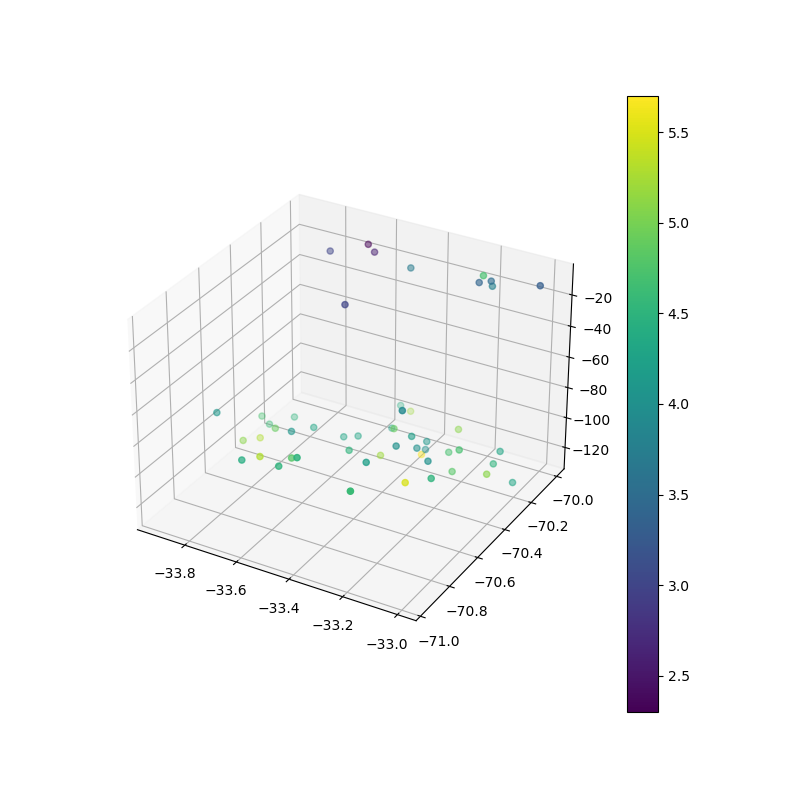

In [13]:
lat = df_filt['Latitud']
lon = df_filt['Longitud']
depth = df_filt['Depth']
scatt_plot(lat,lon,-depth)

In [14]:
df.head()

Date  Latitud  Longitud  Depth  Magnitude
0 2022-12-10 07:25:48   -33.66    -72.11   30.0        5.3
1 2022-12-10 06:41:31   -22.98    -68.27  123.0        5.5
2 2022-11-23 08:53:13   -35.37    -71.37   84.0        5.1
3 2022-11-13 02:24:59   -37.56    -73.69   24.0        6.1
4 2022-11-13 02:24:02   -37.53    -73.82   45.0        5.3

In [15]:
import numpy as np
years = np.arange(df['Date'].min().year,df['Date'].max().year+1,1)

In [16]:
df['Year']=df['Date']
for i in range(len(df)):
    df['Year'][i]=df['Date'][i].year

C:\Users\vicen\AppData\Local\Temp\ipykernel_14752\539858009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'][i]=df['Date'][i].year
C:\Users\vicen\AppData\Local\Temp\ipykernel_14752\539858009.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Year'][i]=df['Date'][i].year


In [17]:
events = df.groupby('Year').count().iloc[:,-1]

In [18]:
import matplotlib.pyplot as plt

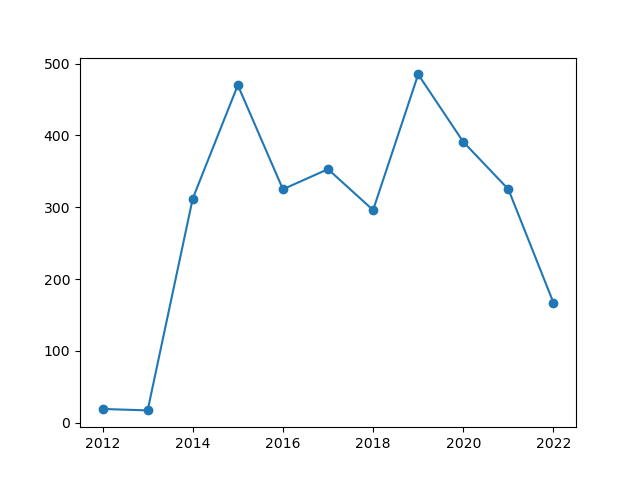

In [19]:
%matplotlib notebook
plt.figure()
plt.plot(events.index,events,'-o')

In [20]:
df['Longitud'].min(),df['Longitud'].max()

(-75.46, -58.39)

In [21]:
df['Latitud'].min(),df['Latitud'].max()

(-62.35, -11.07)

In [22]:
df2 = pd.read_csv('query.csv')
df2['time']=pd.to_datetime(df2['time'])

In [23]:
df2['Year']=df2['time']
for i in range(len(df2)):
    df2['Year'][i]=df2['time'][i].year

C:\Users\vicen\AppData\Local\Temp\ipykernel_14752\3494810380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year'][i]=df2['time'][i].year
C:\Users\vicen\AppData\Local\Temp\ipykernel_14752\3494810380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year'][i]=df2['time'][i].year


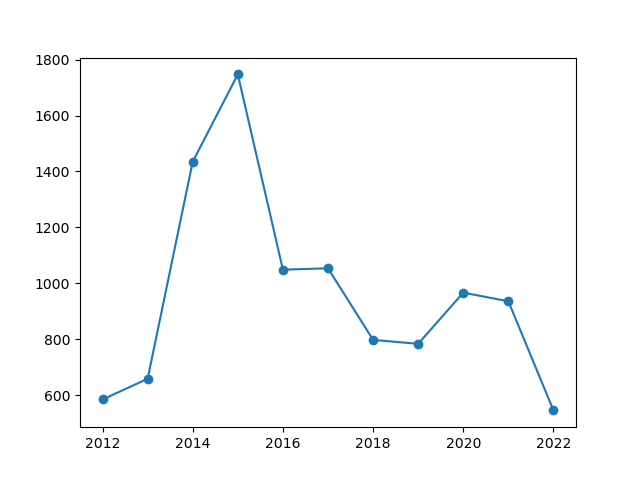

In [24]:
events2 = df2.groupby('Year').count().iloc[:,-1]
%matplotlib notebook
plt.figure()
plt.plot(events2.index,events2,'-o')

In [38]:
import folium
folium.Map(location=[-31.5729,-71.6744], zoom_start=10, tiles='Stamen Terrain', height='70%')